# Texas Education Agency Discipline Classification Project

## Project Goals
-Using data from TEA website, try to determine if school district type can be predicted by student discipline and enrollment numbersdiscipline
-Develop a model to determine if a district is charter or traditional.
-This information on district discipline may be useful to parents and future employees.


## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from env import user, password, host
from scipy.stats import levene, ttest_ind
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import math
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import wrangle as w

## Acquire

* Data acquired from https://rptsvr1.tea.texas.gov/adhocrpt/Disciplinary_Data_Products/Download_All_Districts.html on December 11, 2022 
* It contained 252826 rows and 9 columns that spanned 4 school years of discipline incidents.
* Each observation represents a school district.
* Each column represents a feature of those school district.


In [2]:
df22 = pd.read_csv('DISTRICT_summary_22.csv')
df21 = pd.read_csv('DISTRICT_summary_21.csv')
df20 = pd.read_csv('DISTRICT_summary_20.csv')
df19 = pd.read_csv('DISTRICT_summary_19.csv')

In [3]:
w.prep22(df22)

In [4]:
w.prep21(df21)

In [5]:
w.prep20(df20)

In [6]:
w.prep19(df19)

In [7]:
df=w.df_combine(df19,df20,df21,df22)

In [8]:
df.dist_name.nunique()

1122

## Prepare

*Renamed columns for ease of coding and to shorten column names.

*Removed data columns that did not meet project needs.

*Checked for duplicates, nulls, and -999 and removed those columns.

*Removed districts that did not have both enrollment and disciplined numbers.

*Encoded target variable, charter_status, as 'charter_encoded' {'Yes': 1, 'No': 0}, then dropped 'charter_status' column.

*Outliers were not removed.

*Created a pivot table to access items under the 'heading name' column to create 2 new columns.

*Feature engineered a new column from pivoted columns.

*Merged the pivot table onto the dataframe.

*Reset the index.

*Split data into train, validate, and test (50/30/20).

### Data dictionary

| Feature | Definition | Values |
|:--------|:-----------|:-------
|dist_name| Scool District Name| Categorical|
|charter_encoded| Is the district type a charter school?| {'Yes': 1, 'No': 0} |
|enrollment| # of students enrolled in the district| Numerical |
|disciplined| # of student discipline incidents|Numerical'|
|discipline_percent| # disciplined/# enrolled|Numerical|

In [9]:
train, validate, test= w.split_tea_data(df) 

### Here is a glimpse of the data

In [10]:
#show the first few rows of the train data
train.head()

,dist_name,charter_encoded,enrollment,disciplined,discipline_percent
1598,JIM HOGG COUNTY ISD,0,1222.0,311.0,25.0
3507,EDCOUCH-ELSA ISD,0,4624.0,783.0,17.0
1195,DIMMITT ISD,0,1294.0,216.0,17.0
3820,MARFA ISD,0,293.0,52.0,18.0
1955,THE EXCEL CENTER (FOR ADULTS),1,1361.0,29.0,2.0


In [11]:
train.describe()

,charter_encoded,enrollment,disciplined,discipline_percent
count,2270.000000,2270.000000,2270.000000,2270.000000
mean,0.101322,5320.212335,1113.369163,20.031718
std,0.301821,12342.538088,2695.525538,14.831382
min,0.000000,66.000000,10.000000,0.000000
25%,0.000000,565.000000,58.000000,9.000000
50%,0.000000,1266.000000,206.000000,17.000000
75%,0.000000,3797.750000,841.750000,27.000000
max,1.000000,164515.000000,30720.000000,118.000000


## Explore

### Does enrollment numbers affect charter status? 

In [12]:
cat_vars = ['dist_name', 'charter_encoded']

dist_name
HIGHLAND PARK ISD                    5
MIDWAY ISD                           5
CENTERVILLE ISD                      5
EL CAMPO ISD                         4
YOAKUM ISD                           4
                                    ..
UNION GROVE ISD                      1
RICHARD MILBURN ALTER HIGH SCHOOL    1
ABERNATHY ISD                        1
LITTLE ELM ISD                       1
NECHES ISD                           1
Name: dist_name, Length: 1038, dtype: int64
HIGHLAND PARK ISD                    0.220264
MIDWAY ISD                           0.220264
CENTERVILLE ISD                      0.220264
EL CAMPO ISD                         0.176211
YOAKUM ISD                           0.176211
                                       ...   
UNION GROVE ISD                      0.044053
RICHARD MILBURN ALTER HIGH SCHOOL    0.044053
ABERNATHY ISD                        0.044053
LITTLE ELM ISD                       0.044053
NECHES ISD                           0.044053
Name: dist_

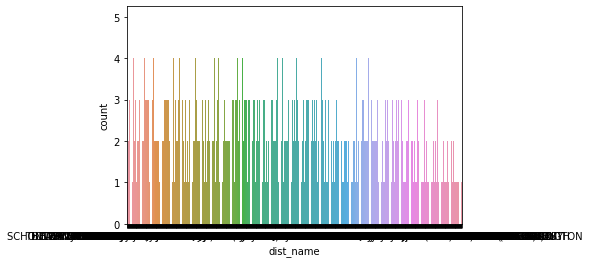

charter_encoded
0    2040
1     230
Name: charter_encoded, dtype: int64
0    89.867841
1    10.132159
Name: charter_encoded, dtype: float64


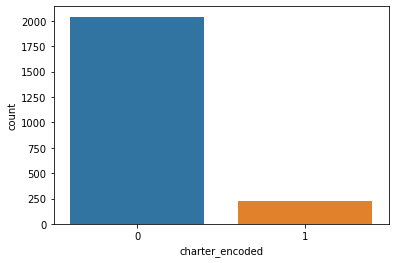

In [13]:
cat_vars = ['dist_name', 'charter_encoded']

### Does disciplined incidents affect charter status?

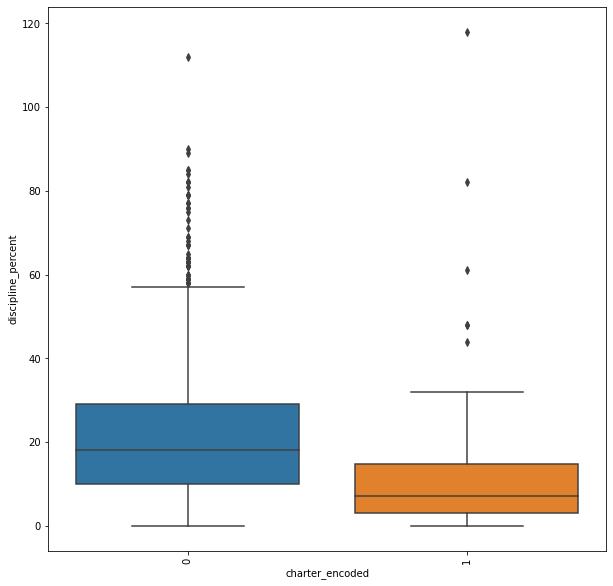

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.boxplot(x=train['charter_encoded'], y=train['discipline_percent']);
plt.xticks(rotation = 90)
plt.show()


### Does disciplne_percent affect charter status?

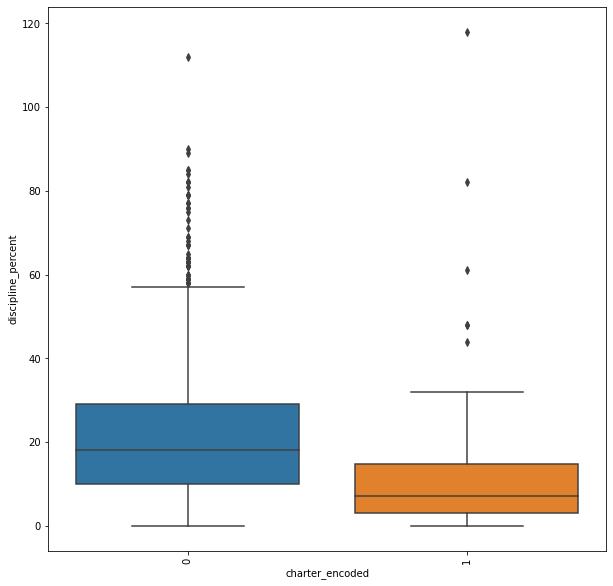

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.boxplot(x=train['charter_encoded'], y=train['discipline_percent']);
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:>

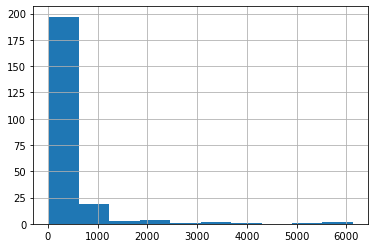

In [16]:
# histogram of churned customers
charterdisc = train[train.charter_encoded==1].disciplined
charterdisc.hist()

<AxesSubplot:>

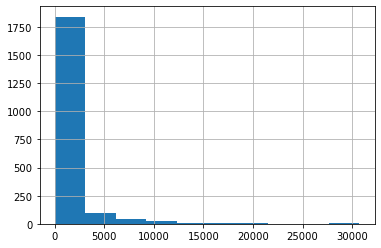

In [17]:
# histogram of non-churned customers
non_charterdisc = train[train.charter_encoded==0].disciplined
non_charterdisc.hist()

In [18]:
mean_a = charterdisc.mean()
mean_b = non_charterdisc.mean()

In [19]:
mean_a, mean_b

(346.204347826087, 1199.8632352941177)

## Hypothesis
Null H: Mean of disciplined students is the same for charter schools and traditional schools.
Alt H: Mean of disciplined students is not the same for charter schools and traditional schools.

In [20]:
# remember that our confidence level determines our alpha, 
# which we use to compare to p
alpha = 0.05

In [21]:
# Mini H0: variances are equal between groups
# Ha: variances are inequal between groups
# alpha: 0.05
stat, pval = stats.levene(charterdisc, non_charterdisc)

In [22]:
pval

1.2935809227188918e-05

In [23]:
# implications of one-tailed two-sampled t-test:
# p will be divided by two because we are only looking at one tail of the curve
# we will pay attention to the sign of our t-statistic
# t, p = t-test: (group A, group B) ==> comparison of mu_a > mu_b
t, p = stats.ttest_ind(charterdisc, non_charterdisc, equal_var=False)
t, p


(-10.13349483513259, 5.350079205664551e-23)

In [24]:
print('Is p less than alpha? ', pval < alpha)

Is p less than alpha?  True


In [25]:
if (t > 0) and ((p / 2) < alpha):
    print('We can reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we fail to reject the null hypothesis


In [26]:
t, p

(-10.13349483513259, 5.350079205664551e-23)

<AxesSubplot:>

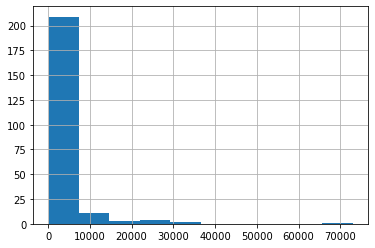

In [27]:
# histogram of churned customers
charterenr = train[train.charter_encoded==1].enrollment
charterenr.hist()

<AxesSubplot:>

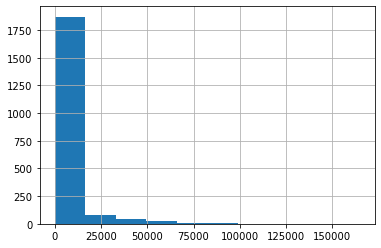

In [28]:
# histogram of non-churned customers
non_charterenr = train[train.charter_encoded==0].enrollment
non_charterenr.hist()

In [29]:
mean_a = charterenr.mean()
mean_b = non_charterenr.mean()

In [30]:
mean_a, mean_b

(3271.8739130434783, 5551.152450980392)

In [31]:
# remember that our confidence level determines our alpha, 
# which we use to compare to p
alpha = 0.05

In [32]:
# Mini H0: variances are equal between groups
# Ha: variances are inequal between groups
# alpha: 0.05
stat, pval = stats.levene(charterenr, non_charterenr)

In [33]:
pval

0.005446919007796719

In [34]:
print('Is p less than alpha? ', pval < alpha)

Is p less than alpha?  True


In [35]:
# implications of one-tailed two-sampled t-test:
# p will be divided by two because we are only looking at one tail of the curve
# we will pay attention to the sign of our t-statistic
# t, p = t-test: (group A, group B) ==> comparison of mu_a > mu_b
t, p = stats.ttest_ind(charterenr, non_charterenr, equal_var=False)
t, p

(-4.281825575984781, 2.279350086099647e-05)

In [36]:
if (t > 0) and ((p / 2) < alpha):
    print('We can reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we fail to reject the null hypothesis


In [37]:
t, p

(-4.281825575984781, 2.279350086099647e-05)

<AxesSubplot:>

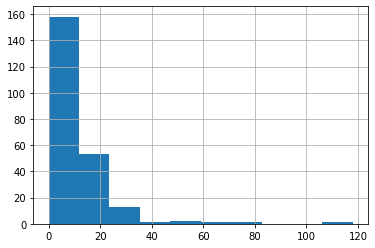

In [38]:
# histogram of churned customers
charterdp = train[train.charter_encoded==1].discipline_percent
charterdp.hist()

<AxesSubplot:>

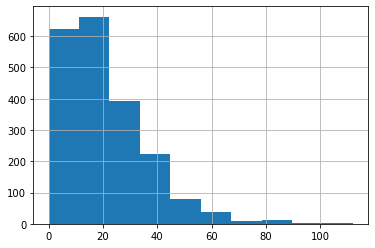

In [39]:
# histogram of non-churned customers
non_charterdp = train[train.charter_encoded==0].discipline_percent
non_charterdp.hist()

In [40]:
mean_a = charterdp.mean()
mean_b = non_charterdp.mean()

In [41]:
mean_a, mean_b

(10.513043478260869, 21.104901960784314)

In [42]:
# remember that our confidence level determines our alpha, 
# which we use to compare to p
alpha = 0.05

Levene’s Test for Equality of Means to determine that equal variance was not assumed, and therefore the difference in mean scores is not due to chance and is statistically significant.# Mini H0: variances are equal between groups.

In [43]:
# Ha: variances are inequal between groups
# alpha: 0.05
stat, pval = stats.levene(charterdp, non_charterdp)

In [44]:
pval

5.283631209647363e-07

In [45]:
print('Is p less than alpha? ', pval < alpha)

Is p less than alpha?  True


In [46]:
# implications of one-tailed two-sampled t-test:
# p will be divided by two because we are only looking at one tail of the curve
# we will pay attention to the sign of our t-statistic
# t, p = t-test: (group A, group B) ==> comparison of mu_a > mu_b
t, p = stats.ttest_ind(charterdp, non_charterdp, equal_var=False)
t, p

(-11.826730463805774, 8.643020389610451e-27)

In [47]:
if (t > 0) and ((p / 2) < alpha):
    print('We can reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

we fail to reject the null hypothesis


In [48]:
t, p

(-11.826730463805774, 8.643020389610451e-27)

## Scaling the data

In [49]:
# assign the train variables
X_train_scaled = train[['enrollment','disciplined','discipline_percent']]
y_train=train[['charter_encoded']]

#assign the validate variables
X_validate_scaled=validate[['enrollment','disciplined','discipline_percent']]
y_validate=validate[['charter_encoded']]

# assign the test variables
X_test_scaled=test[['enrollment','disciplined','discipline_percent']]
y_test=test[['charter_encoded']]

In [50]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['enrollment', 'disciplined', 'discipline_percent'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                           columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [51]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [52]:
train_scaled, validate_scaled, test_scaled

(                          dist_name  charter_encoded  enrollment  disciplined  \
 1598            JIM HOGG COUNTY ISD                0    0.007030     0.009801   
 3507               EDCOUCH-ELSA ISD                0    0.027717     0.025171   
 1195                    DIMMITT ISD                0    0.007467     0.006708   
 3820                      MARFA ISD                0    0.001380     0.001368   
 1955  THE EXCEL CENTER (FOR ADULTS)                1    0.007875     0.000619   
 ...                             ...              ...         ...          ...   
 1993                  FRUITVALE ISD                0    0.002426     0.000749   
 1530                     ABBOTT ISD                0    0.001386     0.000944   
 530                    LOVELADY ISD                0    0.003089     0.001661   
 2153                   REDWATER ISD                0    0.006792     0.007652   
 3485             ELYSIAN FIELDS ISD                0    0.004889     0.006675   
 
       discipl

In [53]:
X_train_scaled.head()

,enrollment,disciplined,discipline_percent
1598,1222.0,311.0,25.0
3507,4624.0,783.0,17.0
1195,1294.0,216.0,17.0
3820,293.0,52.0,18.0
1955,1361.0,29.0,2.0


In [54]:
y_train.tail()

,charter_encoded
1993,0
1530,0
530,0
2153,0
3485,0


In [55]:
y_train.head()

,charter_encoded
1598,0
3507,0
1195,0
3820,0
1955,1


In [56]:
y_train.value_counts()

charter_encoded
0                  2040
1                   230
dtype: int64

## Baseline

In [57]:
# The mode is a great baseline
baseline = y_train.mode()

In [58]:
baseline

,charter_encoded
0,0


In [59]:
X_train_scaled['baseline_prediction'] = 0
X_train_scaled

,enrollment,disciplined,discipline_percent,baseline_prediction
1598,1222.0,311.0,25.0,0
3507,4624.0,783.0,17.0,0
1195,1294.0,216.0,17.0,0
3820,293.0,52.0,18.0,0
1955,1361.0,29.0,2.0,0
...,...,...,...,...
1993,465.0,33.0,7.0,0
1530,294.0,39.0,13.0,0
530,574.0,61.0,11.0,0
2153,1183.0,245.0,21.0,0


In [60]:
actual = y_train
predictions = X_train_scaled.baseline_prediction

In [61]:
pd.crosstab(y_train['charter_encoded'], X_train_scaled.baseline_prediction)

baseline_prediction,0
charter_encoded,
0,2040
1,230


In [62]:
# Creates a boolean array where "No" becomes True and "Yes" becomes False
(y_train == 0)

,charter_encoded
1598,True
3507,True
1195,True
3820,True
1955,False
...,...
1993,True
1530,True
530,True
2153,True


In [63]:
# Takes the .mean() of the boolean array that represents the proportion 
# that would also match our baseline prediction
(y_train == 0).mean() 

charter_encoded    0.898678
dtype: float64

In [64]:
X_validate_scaled['baseline_prediction'] = 0

In [65]:
X_test_scaled['baseline_prediction'] = 0

# Model: Decision Tree

In [66]:
# Create the decision tree object and specify hyperparams
tree = DecisionTreeClassifier(max_depth = 3, random_state=123)

In [67]:
tree

DecisionTreeClassifier(max_depth=3, random_state=123)

In [68]:
tree.fit(X_train_scaled, y_train)

# Rudimentary visualization of model structure
print(export_text(tree, feature_names=X_train_scaled.columns.tolist()))

|--- discipline_percent <= 4.50
|   |--- enrollment <= 440.50
|   |   |--- enrollment <= 332.50
|   |   |   |--- class: 0
|   |   |--- enrollment >  332.50
|   |   |   |--- class: 0
|   |--- enrollment >  440.50
|   |   |--- disciplined <= 72.00
|   |   |   |--- class: 1
|   |   |--- disciplined >  72.00
|   |   |   |--- class: 0
|--- discipline_percent >  4.50
|   |--- discipline_percent <= 25.50
|   |   |--- discipline_percent <= 8.50
|   |   |   |--- class: 0
|   |   |--- discipline_percent >  8.50
|   |   |   |--- class: 0
|   |--- discipline_percent >  25.50
|   |   |--- discipline_percent <= 115.00
|   |   |   |--- class: 0
|   |   |--- discipline_percent >  115.00
|   |   |   |--- class: 1



[Text(0.5, 0.875, 'discipline_percent <= 4.5\ngini = 0.182\nsamples = 2270\nvalue = [2040, 230]\nclass = 0'),
 Text(0.25, 0.625, 'enrollment <= 440.5\ngini = 0.491\nsamples = 211\nvalue = [120, 91]\nclass = 0'),
 Text(0.125, 0.375, 'enrollment <= 332.5\ngini = 0.114\nsamples = 33\nvalue = [31, 2]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.208\nsamples = 17\nvalue = [15, 2]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 16\nvalue = [16, 0]\nclass = 0'),
 Text(0.375, 0.375, 'disciplined <= 72.0\ngini = 0.5\nsamples = 178\nvalue = [89, 89]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.472\nsamples = 126\nvalue = [48, 78]\nclass = 1'),
 Text(0.4375, 0.125, 'gini = 0.334\nsamples = 52\nvalue = [41, 11]\nclass = 0'),
 Text(0.75, 0.625, 'discipline_percent <= 25.5\ngini = 0.126\nsamples = 2059\nvalue = [1920, 139]\nclass = 0'),
 Text(0.625, 0.375, 'discipline_percent <= 8.5\ngini = 0.162\nsamples = 1416\nvalue = [1290, 126]\nclass = 0'),
 Text(0.5625, 0.125, 'gini = 0.244\nsamples

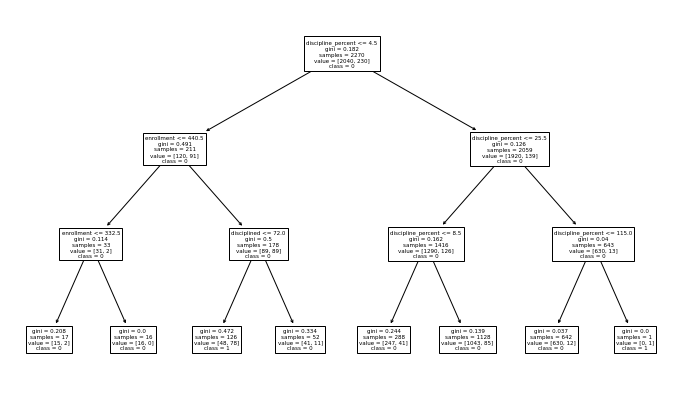

In [69]:
# Visualize the tree
plt.figure(figsize=(12, 7))
plot_tree(tree, feature_names=X_train_scaled.columns, class_names=tree.classes_.astype(str))
#plt.show()

In [70]:
y_pred=tree.predict(X_train_scaled)

In [71]:
y_pred_proba = tree.predict_proba(X_train_scaled)


In [72]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree.score(X_train_scaled, y_train)))

Accuracy of Decision Tree classifier on training set: 0.91


# Create a confusion matrix

In [73]:
tree.predict(X_train_scaled)

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
predictions = tree.predict(X_train_scaled)
actual = y_train

In [75]:
confusion_matrix(actual, predictions)


array([[1992,   48],
       [ 151,   79]])

In [76]:
pd.crosstab(y_train['charter_encoded'], tree.predict(X_train_scaled))

col_0,0,1
charter_encoded,,
0,1992,48
1,151,79


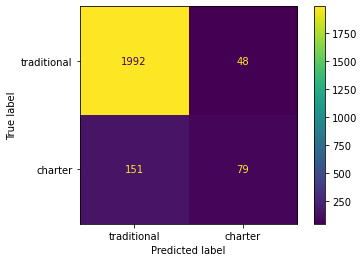

In [77]:
plot_confusion_matrix(tree, X_train_scaled, y_train, display_labels=['traditional', 'charter'])


In [78]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2040
           1       0.62      0.34      0.44       230

    accuracy                           0.91      2270
   macro avg       0.78      0.66      0.70      2270
weighted avg       0.90      0.91      0.90      2270



# Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=3, random_state=123)
rf

RandomForestClassifier(max_depth=3, random_state=123)

In [80]:
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=3, random_state=123)

In [81]:
print(rf.feature_importances_)


[0.2455151 0.1828066 0.5716783 0.       ]


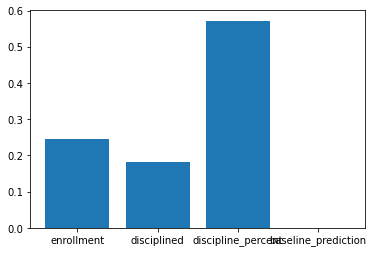

In [82]:
plt.bar(X_train_scaled.columns, rf.feature_importances_)
plt.show()

In [83]:
y_pred = rf.predict(X_train_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
y_pred_proba = rf.predict_proba(X_train_scaled)
y_pred_proba

array([[0.95560118, 0.04439882],
       [0.92707726, 0.07292274],
       [0.93087676, 0.06912324],
       ...,
       [0.91673727, 0.08326273],
       [0.94054092, 0.05945908],
       [0.95362934, 0.04637066]])

In [85]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_scaled, y_train)))

Accuracy of random forest classifier on training set: 0.91


In [86]:
cm = confusion_matrix(y_train, y_pred)
print(cm)

[[2018   22]
 [ 178   52]]


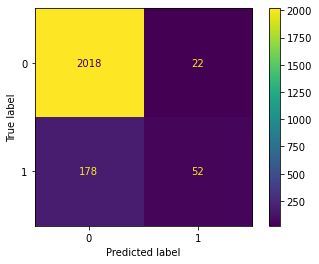

In [87]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

disp.plot()
plt.show()

In [88]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2040
           1       0.70      0.23      0.34       230

    accuracy                           0.91      2270
   macro avg       0.81      0.61      0.65      2270
weighted avg       0.90      0.91      0.89      2270



# K-Nearest Neighbor

In [89]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [90]:
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier()

In [91]:
y_pred = knn.predict(X_train_scaled)


In [92]:
y_pred_proba = knn.predict_proba(X_train_scaled)


In [93]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))

Accuracy of KNN classifier on training set: 0.92


In [94]:
print(confusion_matrix(y_train, y_pred))

[[2010   30]
 [ 152   78]]


In [95]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2040
           1       0.72      0.34      0.46       230

    accuracy                           0.92      2270
   macro avg       0.83      0.66      0.71      2270
weighted avg       0.91      0.92      0.91      2270



# Logistic Regression

In [96]:
# Define the logistic regression model
logit = LogisticRegression(C=1, random_state=123)

In [97]:
#  fit the model on train data
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1, random_state=123)

In [98]:
# now use the model to make predictions
y_pred = logit.predict(X_train_scaled)

In [99]:
#take a look at predictions
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
# look at predicted probabilites for first 10 observations
logit.predict_proba(X_train_scaled)[:10]

array([[0.95517112, 0.04482888],
       [0.91702005, 0.08297995],
       [0.91195836, 0.08804164],
       [0.91748174, 0.08251826],
       [0.72792652, 0.27207348],
       [0.9594673 , 0.0405327 ],
       [0.99711388, 0.00288612],
       [0.94626456, 0.05373544],
       [0.9743849 , 0.0256151 ],
       [0.83633725, 0.16366275]])

In [101]:
logit.classes_

array([0, 1])

In [102]:
# View raw probabilities (output from the model)

y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['traditional', 'charter'])
y_pred_proba.head().round(3)

,traditional,charter
0,0.955,0.045
1,0.917,0.083
2,0.912,0.088
3,0.917,0.083
4,0.728,0.272


In [103]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2040
           1       0.00      0.00      0.00       230

    accuracy                           0.90      2270
   macro avg       0.45      0.50      0.47      2270
weighted avg       0.81      0.90      0.85      2270



In [104]:
# look at model 1 coefficents
 
print('Coefficient: \n', logit.coef_[0])

Coefficient: 
 [-1.84559825e-05 -5.79795044e-06 -9.02539262e-02  0.00000000e+00]


In [105]:
# Make a dataframe of coefficients and feature names

log_coeffs = pd.DataFrame(logit.coef_[0], index = X_train_scaled.columns,
                          columns = ['coeffs']).sort_values(by = 'coeffs', ascending = True)
log_coeffs

,coeffs
discipline_percent,-0.090254
enrollment,-0.000018
disciplined,-0.000006
baseline_prediction,0.000000


In [106]:
# convert from log odds to odds (exponentiate)
odds = np.exp(log_coeffs)
odds


,coeffs
discipline_percent,0.913699
enrollment,0.999982
disciplined,0.999994
baseline_prediction,1.000000


## Best Performing Model is KNN (now to validate and test)

In [107]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [108]:
knn.fit(X_validate_scaled, y_validate)

KNeighborsClassifier()

In [109]:
y_pred = knn.predict(X_validate_scaled)

In [110]:
y_pred_proba = knn.predict_proba(X_validate_scaled)

In [111]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_validate_scaled, y_validate)))

Accuracy of KNN classifier on training set: 0.91


In [112]:
print(confusion_matrix(y_validate, y_pred))

[[864  11]
 [ 74  25]]


In [113]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       875
           1       0.69      0.25      0.37        99

    accuracy                           0.91       974
   macro avg       0.81      0.62      0.66       974
weighted avg       0.90      0.91      0.89       974



In [114]:
pred_dict = {
    'model': [],
    'accuracy': [],
    'true_positive_rate': [],
    'false_positive_rate': [],
    'true_negative_rate': [],
    'false_negative_rate': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'support_0': [],
    'support_1': []
}

for n in [5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_validate_scaled, y_validate)
    
    y_preds = knn.predict(X_validate_scaled)
    
    TN, FP, FN, TP = confusion_matrix(y_validate, y_preds).ravel()
    ALL = TP + TN + FP + FN
    
    accuracy = (TP + TN)/ALL
    true_positive_rate = TP/(TP+FN)
    false_positive_rate = FP/(FP+TN)
    true_negative_rate = TN/(TN+FP)
    false_negative_rate = FN/(FN+TP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
    support_pos = TP + FN
    support_neg = FP + TN
    
    pred_dict['model'].append(f'knn_n_{n}')
    pred_dict['accuracy'].append(accuracy)
    pred_dict['true_positive_rate'].append(true_positive_rate)
    pred_dict['false_positive_rate'].append(false_positive_rate)
    pred_dict['true_negative_rate'].append(true_negative_rate)
    pred_dict['false_negative_rate'].append(false_negative_rate)
    pred_dict['precision'].append(precision)
    pred_dict['recall'].append(recall)
    pred_dict['f1_score'].append(f1_score)
    pred_dict['support_0'].append(support_pos)
    pred_dict['support_1'].append(support_neg)

In [115]:
pd.DataFrame(pred_dict)

,model,accuracy,true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate,precision,recall,f1_score,support_0,support_1
0,knn_n_5,0.912731,0.252525,0.012571,0.987429,0.747475,0.694444,0.252525,0.370370,99,875
1,knn_n_10,0.906571,0.131313,0.005714,0.994286,0.868687,0.722222,0.131313,0.222222,99,875
2,knn_n_20,0.901437,0.030303,0.000000,1.000000,0.969697,1.000000,0.030303,0.058824,99,875


In [116]:
pd.DataFrame(pred_dict).T

,0,1,2
model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.912731,0.906571,0.901437
true_positive_rate,0.252525,0.131313,0.030303
false_positive_rate,0.012571,0.005714,0.0
true_negative_rate,0.987429,0.994286,1.0
false_negative_rate,0.747475,0.868687,0.969697
precision,0.694444,0.722222,1.0
recall,0.252525,0.131313,0.030303
f1_score,0.37037,0.222222,0.058824
support_0,99,99,99


In [117]:
validate_scaled_pred_df = pd.DataFrame(pred_dict).T
validate_scaled_pred_df.columns = validate_scaled_pred_df.iloc[0]
validate_scaled_pred_df = validate_scaled_pred_df.drop(validate_scaled_pred_df.index[0])
validate_scaled_pred_df

model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.912731,0.906571,0.901437
true_positive_rate,0.252525,0.131313,0.030303
false_positive_rate,0.012571,0.005714,0.0
true_negative_rate,0.987429,0.994286,1.0
false_negative_rate,0.747475,0.868687,0.969697
precision,0.694444,0.722222,1.0
recall,0.252525,0.131313,0.030303
f1_score,0.37037,0.222222,0.058824
support_0,99,99,99
support_1,875,875,875


## Test

In [118]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [119]:
knn.fit(X_test_scaled, y_test)

KNeighborsClassifier()

In [120]:
y_pred = knn.predict(X_test_scaled)

In [121]:
y_pred_proba = knn.predict_proba(X_test_scaled)

In [122]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

Accuracy of KNN classifier on training set: 0.91


In [123]:
print(confusion_matrix(y_test, y_pred))

[[723   6]
 [ 67  15]]


In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       729
           1       0.71      0.18      0.29        82

    accuracy                           0.91       811
   macro avg       0.81      0.59      0.62       811
weighted avg       0.89      0.91      0.89       811



In [125]:
pred_dict = {
    'model': [],
    'accuracy': [],
    'true_positive_rate': [],
    'false_positive_rate': [],
    'true_negative_rate': [],
    'false_negative_rate': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'support_0': [],
    'support_1': []
}

for n in [5, 10, 20]:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_test_scaled, y_test)
    
    y_preds = knn.predict(X_test_scaled)
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_preds).ravel()
    ALL = TP + TN + FP + FN
    
    accuracy = (TP + TN)/ALL
    true_positive_rate = TP/(TP+FN)
    false_positive_rate = FP/(FP+TN)
    true_negative_rate = TN/(TN+FP)
    false_negative_rate = FN/(FN+TP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
    support_pos = TP + FN
    support_neg = FP + TN
    
    pred_dict['model'].append(f'knn_n_{n}')
    pred_dict['accuracy'].append(accuracy)
    pred_dict['true_positive_rate'].append(true_positive_rate)
    pred_dict['false_positive_rate'].append(false_positive_rate)
    pred_dict['true_negative_rate'].append(true_negative_rate)
    pred_dict['false_negative_rate'].append(false_negative_rate)
    pred_dict['precision'].append(precision)
    pred_dict['recall'].append(recall)
    pred_dict['f1_score'].append(f1_score)
    pred_dict['support_0'].append(support_pos)
    pred_dict['support_1'].append(support_neg)

In [126]:
pd.DataFrame(pred_dict)

,model,accuracy,true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate,precision,recall,f1_score,support_0,support_1
0,knn_n_5,0.909988,0.182927,0.00823,0.99177,0.817073,0.714286,0.182927,0.291262,82,729
1,knn_n_10,0.901356,0.024390,0.00000,1.00000,0.975610,1.000000,0.024390,0.047619,82,729
2,knn_n_20,0.898890,0.000000,0.00000,1.00000,1.000000,NaN,0.000000,NaN,82,729


In [127]:
pd.DataFrame(pred_dict).T

,0,1,2
model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.909988,0.901356,0.89889
true_positive_rate,0.182927,0.02439,0.0
false_positive_rate,0.00823,0.0,0.0
true_negative_rate,0.99177,1.0,1.0
false_negative_rate,0.817073,0.97561,1.0
precision,0.714286,1.0,NaN
recall,0.182927,0.02439,0.0
f1_score,0.291262,0.047619,NaN
support_0,82,82,82


In [128]:
test_scaled_pred_df = pd.DataFrame(pred_dict).T
test_scaled_pred_df.columns = test_scaled_pred_df.iloc[0]
test_scaled_pred_df = test_scaled_pred_df.drop(test_scaled_pred_df.index[0])
test_scaled_pred_df

model,knn_n_5,knn_n_10,knn_n_20
accuracy,0.909988,0.901356,0.89889
true_positive_rate,0.182927,0.02439,0.0
false_positive_rate,0.00823,0.0,0.0
true_negative_rate,0.99177,1.0,1.0
false_negative_rate,0.817073,0.97561,1.0
precision,0.714286,1.0,NaN
recall,0.182927,0.02439,0.0
f1_score,0.291262,0.047619,NaN
support_0,82,82,82
support_1,729,729,729


## Conclusion

After modeling with 4 models, I have concluded that even though I had a "best" it didn't predict charter school status any better than baseline.  Looking at the data, some school districts have more discipline incidents than they do students enrolled, which really makes me wonder what the drivers are behind such a dramatic number.

## Next Steps

I will use this data for another individual project and I would use more of the discipline data types and not just the whole number.  I will be able to break down the discipline by socio-economic staus, race, ethnicity, special. ed. services receiver, location, and by offense.

## Recommendations

Revisit this data over the holidays and feature engineer more variables, and look into other discipline reports that break it down by school.  I think this will better help in future modeling.